<a href="https://colab.research.google.com/github/ykitaguchi77/Kaggle/blob/main/Bunkruptcy-prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Download Kaggle dataset**

## Google Driveのマウント

In [1]:
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


## データセットの準備
Kaggleと同じコードで動くよう、フォルダの関係を調整

In [2]:
import os
import shutil

# kaggle ライブラリのインストール
!pip install kaggle

# 一時フォルダに .kaggleフォルダを作成
!mkdir ~/.kaggle

# MyDrive の kaggle.json を一時フォルダ内の .kaggleフォルダにコピー
!cp /content/drive/MyDrive/Kaggle/kaggle.json ~/.kaggle/

# アクセス権限の設定
!chmod 600 ~/.kaggle/kaggle.json

!mkdir ~/.kaggle



os.makedirs("./input/bankruptcy-risk-prediction", exist_ok=True)
os.makedirs("./output", exist_ok=True)

# zipファイルのダウンロード
!kaggle competitions download -c bankruptcy-risk-prediction -p /content
# 解凍
!unzip ./bankruptcy-risk-prediction.zip -d ./input/bankruptcy-risk-prediction

#Zipフォルダを削除
!rm ./bankruptcy-risk-prediction.zip

#作業フォルダを作成

os.makedirs("./Kaggle", exist_ok=True)
os.chdir("./Kaggle")


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
mkdir: cannot create directory ‘/root/.kaggle’: File exists
  0% 0.00/22.3k [00:00<?, ?B/s]
100% 22.3k/22.3k [00:00<00:00, 15.7MB/s]
Archive:  ./bankruptcy-risk-prediction.zip
  inflating: ./input/bankruptcy-risk-prediction/submission_example.csv  
  inflating: ./input/bankruptcy-risk-prediction/test.csv  
  inflating: ./input/bankruptcy-risk-prediction/train.csv  


In [3]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split


import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')



#**Load data**

In [5]:
# load train.csv
train_df = pd.read_csv('../input/bankruptcy-risk-prediction/train.csv')

# load test.csv
test_df = pd.read_csv('../input/bankruptcy-risk-prediction/test.csv')

# load submission_example.csv
submission = pd.read_csv('../input/bankruptcy-risk-prediction/submission_example.csv')


print(f'train_df.shape = {train_df.shape}')
print(f'test_df.shape = {test_df.shape}')
print(f'submission.shape = {submission.shape}')

pd.set_option('display.max_rows', 3)
pd.set_option('display.max_columns', 1000)

train_df
test_df

train_df.shape = (800, 22)
test_df.shape = (200, 21)
submission.shape = (200, 2)


,id,sum,term,payment,guarantees,reason,credits,other_credits,credit_report,marital_status,age,employment,qualification,immigrant,residence_since,accommodation,estate,savings,dependents,phone,status
0,800,1597,24,4,none,education,2,none,critical account or other credits existing(not...,male single,54,7+ y.,skilled employee,yes,4,for free,unknown or no property,less-than 100 cu,2,none,no checking account
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,999,4576,45,3,none,used car,1,none,critical account or other credits existing(not...,male single,27,unemployed,skilled employee,yes,4,own,car or other,100 to 500 cu,1,none,0 to 200 cu


In [ ]:
# #Profiling用。Runtimeの再起動を要求されるので先にインポートしておく
# !pip install pandas-profiling
# !pip install -U pandas_profiling
# !pip uninstall markupsafe
# !pip install markupsafe==2.0.1 #エラー対応

# import pandas as pd
# import pandas_profiling as pdp

# pdp.ProfileReport(train_df)


In [ ]:
# check data type(train_data)
print(train_df.dtypes)

# check missing values (train_data)
print(train_df.isnull().sum())

# check missing values (test_data)
print(test_df.isnull().sum())

In [ ]:
# check train_data describe
train_df.describe().T

In [ ]:
#Object項目の分布図を縦に並べて表示
import seaborn as sns
import matplotlib.pyplot as plt

categories_obj = train_df.columns[train_df.dtypes=='object'].values.tolist()
#categories

sns.set()

fig, axes = plt.subplots(len(categories_obj),1,figsize=(9,9*len(categories_obj)))   

for i in range(len(categories_obj)):
    sns.barplot(x=categories_obj[i], y="bankruptcy", data=train_df, palette="Set3", ax=axes[i])

plt.show()


for j in range(len(categories_obj)):
    print(train_df.groupby(categories_obj[j]).count().index.to_list())


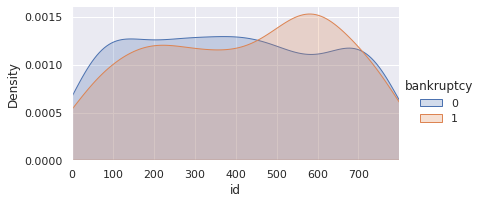

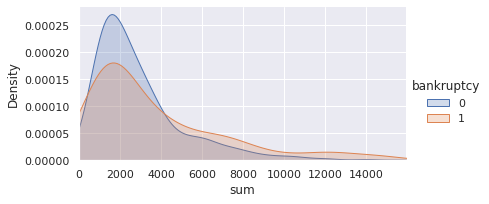

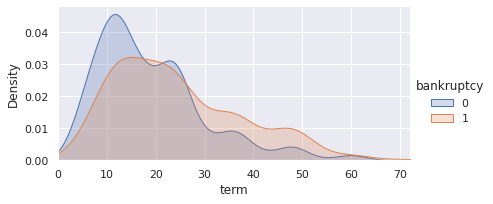

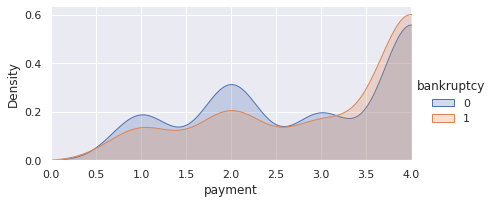

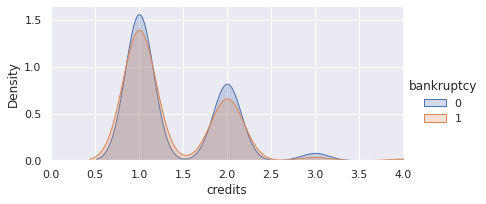

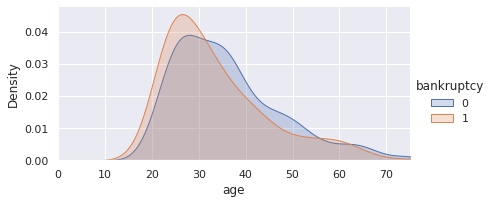

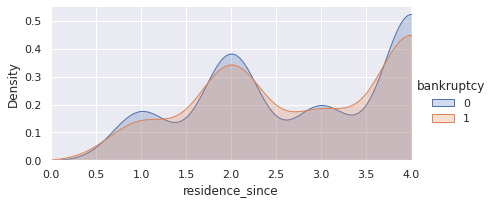

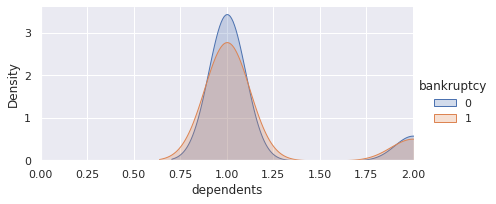

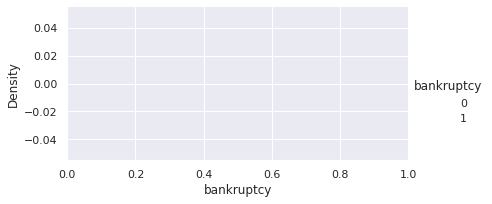

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

In [85]:
#Object以外の項目の分布図を縦に並べて表示
import seaborn as sns
import matplotlib.pyplot as plt

categories_float = train_df.columns[train_df.dtypes=='int64']

sns.set()
#fig, axes = plt.subplots(len(categories),1,figsize=(9,9*len(categories)))   

for i in range(len(categories_float)):
    fare = sns.FacetGrid(train_df, hue="bankruptcy",aspect=2)
    fare.map(sns.kdeplot,categories_float[i],shade= True)
    fare.set(xlim=(0, train_df[categories_float[i]].max()))
    fare.add_legend()
plt.show()


for j in range(len(categories_float)):
    print(train_df.groupby(categories_float[j]).count().index.to_list())


#**PyCaret**

In [ ]:
train_df.columns

Index(['id', 'sum', 'term', 'payment', 'guarantees', 'reason', 'credits',
       'other_credits', 'credit_report', 'marital_status', 'age', 'employment',
       'qualification', 'immigrant', 'residence_since', 'accommodation',
       'estate', 'savings', 'dependents', 'phone', 'status', 'bankruptcy'],
      dtype='object')

In [ ]:
!pip install pycaret
!pip install pandas-profiling==3.1.0

In [ ]:
train_df.shape

(800, 22)

In [ ]:
# init setup
from pycaret.classification import *
categorical_feautres = []
s = setup(data = train_df, target = 'bankruptcy', categorical_features=[], numeric_features=['sum', 'term', 'payment', 'guarantees', 'reason', 'credits', 'other_credits', 'credit_report', 'marital_status', 'age', 'employment', 'qualification', 'immigrant', 'residence_since', 'accommodation', 'estate', 'savings', 'dependents', 'phone', 'status'], session_id=123)
#s = setup(data = train_df, target = 'bankruptcy', session_id=123)

,Description,Value
0,session_id,123
1,Target,bankruptcy
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(800, 22)"
5,Missing Values,False
6,Numeric Features,21
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


INFO:logs:create_model_container: 0
INFO:logs:master_model_container: 0
INFO:logs:display_container: 1
INFO:logs:Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=True, features_todrop=[],
                                      id_columns=['id'],
                                      ml_usecase='classification',
                                      numerical_features=['sum', 'term',
                                                          'payment',
                                                          'guarantees',
                                                          'reason', 'credits',
                                                          'other_credits',
                                                          'credit_report',
                                                          'marital_status',
                                                      

In [ ]:
best_model = compare_models(sort="AUC")

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lda,Linear Discriminant Analysis,0.7710,0.7989,0.5176,0.6715,0.5768,0.4241,0.4361,0.016
rf,Random Forest Classifier,0.7835,0.7977,0.4463,0.7559,0.5549,0.4236,0.4533,0.488
nb,Naive Bayes,0.7549,0.7869,0.4099,0.6573,0.4917,0.3451,0.3676,0.015
lightgbm,Light Gradient Boosting Machine,0.7495,0.7792,0.4816,0.6218,0.5361,0.3692,0.3790,0.114
qda,Quadratic Discriminant Analysis,0.7012,0.7731,0.6364,0.5355,0.5726,0.3542,0.3576,0.016
gbc,Gradient Boosting Classifier,0.7639,0.7699,0.4761,0.6602,0.5467,0.3937,0.4072,0.119
et,Extra Trees Classifier,0.7460,0.7684,0.3930,0.6502,0.4802,0.3257,0.3491,0.463
ada,Ada Boost Classifier,0.7406,0.7351,0.4651,0.6157,0.5086,0.3424,0.3599,0.103
lr,Logistic Regression,0.7209,0.7227,0.2320,0.6008,0.3272,0.1953,0.2322,0.344
dt,Decision Tree Classifier,0.6728,0.6092,0.4482,0.4707,0.4505,0.2214,0.2262,0.015


INFO:logs:create_model_container: 14
INFO:logs:master_model_container: 14
INFO:logs:display_container: 2
INFO:logs:LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)
INFO:logs:compare_models() succesfully completed......................................


In [ ]:
print(best_model)

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)


In [ ]:
lda = create_model("lightgbm")

In [ ]:
tuned_lda = tune_model(lda)

In [ ]:
plot_model(tuned_lda, plot = 'auc')


In [ ]:
plot_model(tuned_lda, plot = 'pr')


In [ ]:
plot_model(tuned_lda, plot='feature')

In [ ]:
plot_model(tuned_lda, plot = 'confusion_matrix')


In [ ]:
predict_model(tuned_lda);

In [ ]:
# finalize rf model
final_lda = finalize_model(tuned_lda)

predict_model(final_lda);


In [ ]:
unseen_predictions = predict_model(final_lda, data=test_df)


In [ ]:
unseen_predictions

#**Data processing**

In [ ]:
#nominal to proportional scale (名義尺度→連続尺度)
categories_obj = train_df.columns[train_df.dtypes=='object'].values.tolist()
categories_obj.extend(["dependents", "residence_since", "credits", "payment"])

for obj in categories_obj:
    rate = train_df.groupby(obj).mean()["bankruptcy"].tolist() #show rate of bankruptcy in each nominal indices
    indices = train_df.groupby(obj).count().index.to_list()

    # print(rate)
    # print("")
    
    #index (=nominal scale) to rate (=proportional scale)
    for i in range(len(rate)):
        train_df[obj] = train_df[obj].replace(indices[i], rate[i])
        test_df[obj] = test_df[obj].replace(indices[i], rate[i])

train_df

,id,sum,term,payment,guarantees,reason,credits,other_credits,credit_report,marital_status,age,employment,qualification,immigrant,residence_since,accommodation,estate,savings,dependents,phone,status,bankruptcy
0,0,1169,6,0.344648,0.298077,0.224215,0.287356,0.277182,0.182979,0.249428,67,0.256158,0.286282,0.306598,0.297872,0.261404,0.222707,0.211268,0.296188,0.275862,0.473684,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
799,799,1549,9,0.344648,0.298077,0.385870,0.307992,0.277182,0.308962,0.249428,35,0.406015,0.294118,0.306598,0.305785,0.261404,0.222707,0.211268,0.296188,0.313929,0.411504,0


In [ ]:
from sklearn.preprocessing import OneHotEncoder

# obtain object data type as list (outcomeが数値でないラベルを抜き出す)
categories = train_df.columns[train_df.dtypes=='object'].values.tolist()

# One-hot Encoding
for cat in categories:
    
    # generate Label Encoder object
    train_df_encoder = pd.get_dummies(train_df[[cat]])
    test_df_encoder = pd.get_dummies(test_df[[cat]])

    #concat 
    train_df = pd.concat([train_df, train_df_encoder],axis=1)
    test_df = pd.concat([test_df, test_df_encoder], axis=1)
    
    #drop original (object data) categories
    train_df.drop(cat, axis=1, inplace=True)
    test_df.drop(cat, axis=1, inplace=True)

#drop duplicated columns
train_df.loc[:,~train_df.columns.duplicated()]
test_df.loc[:,~test_df.columns.duplicated()]

,id,sum,term,payment,guarantees,reason,credits,other_credits,credit_report,marital_status,age,employment,qualification,immigrant,residence_since,accommodation,estate,savings,dependents,phone,status
0,800,1597,24,0.344648,0.298077,0.444444,0.287356,0.277182,0.182979,0.249428,54,0.256158,0.286282,0.306598,0.297872,0.400000,0.429688,0.348739,0.313559,0.313929,0.112903
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,999,4576,45,0.283333,0.298077,0.148148,0.307992,0.277182,0.182979,0.249428,27,0.395833,0.286282,0.306598,0.297872,0.261404,0.296992,0.337079,0.296188,0.313929,0.411504


#**Neural network_Pytorch**

In [ ]:
#Dataset

import scipy.stats
from sklearn import preprocessing

# target label
y = train_df['bankruptcy']

# predictor features
X = train_df.drop(['id', 'bankruptcy'], axis=1)
X = X.apply(scipy.stats.zscore, axis=0) #standardization

# list of categorical features
category_list = X.columns[X.dtypes=='category'].values.tolist()

# standardize testset
test_df = test_df.iloc[:, 0:20].apply(scipy.stats.zscore, axis=0)

In [ ]:
#Split the data
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(X, y, test_size = 0.2)
x_train.shape

(640, 20)

In [ ]:
#Define the model 
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        #Note that x_train.shape[1]=20 is the number of columns in the input matrix. 
        self.fc1 = nn.Linear(x_train.shape[1], 100)
        self.fc2 = nn.Linear(100,100)
        self.fc3 = nn.Linear(100,100)
        #270 is arbitrary, but needs to be consistent.  2 is the number of classes in the output (died/survived)
        self.fc4 = nn.Linear(100, 2)
        
    def forward(self, x):
        x = self.fc1(x)
        #x = F.dropout(x, p=0.1)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.fc4(x)
        x = torch.sigmoid(x)  #signmoid flattens to probability 0-1. 
        
        return x
    
net = Net()

In [ ]:
#Define training
batch_size = 50
num_epochs = 100
learning_rate = 0.01
batch_no = len(x_train) // batch_size

#define loss function and optimizer 
#Adam is a specific flavor of gradient decent which is typically better
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

In [ ]:
from sklearn.utils import shuffle
from torch.autograd import Variable
running_loss = 0.0
for epoch in range(num_epochs):
    x_train, y_train = shuffle(x_train, y_train)
    # Mini batch learning
    for i in range(batch_no):
        start = i * batch_size
        end = start + batch_size
        inputs = Variable(torch.FloatTensor(x_train[start:end].values))
        labels = Variable(torch.LongTensor(y_train[start:end].values))
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        
    print('Epoch {}'.format(epoch+1), "loss: ",running_loss)
    running_loss = 0.0


In [ ]:
test_df.shape

(200, 21)

Accuracy 0.94 for a total of  640 records
Accuracy 0.75 for a total of  160 records
Area_under_ROC : 0.908628136569313
Area_under_ROC : 0.7222791555646648
returning predictions


array([1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0,
       0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0])

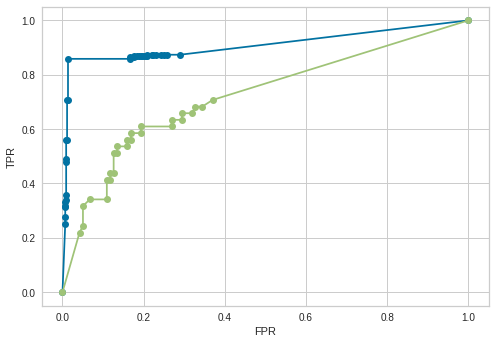

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score

#This is a little bit tricky to get the resulting prediction.  
def calculate_accuracy(x,y=[]):
  # Evaluate the model with the test set. 
  test_var = Variable(torch.FloatTensor(x.values), requires_grad=True)
  with torch.no_grad():   
      output = net(test_var) #This outputs the probability for each class.
  values, labels = torch.max(output, 1)
  if len(y) != 0:
      num_right = np.sum(labels.data.numpy() == y)
      print('Accuracy {:.2f}'.format(num_right / len(y)), "for a total of ", len(y), "records")
  else:
      print("returning predictions")
      return labels.data.numpy()

def calculate_roc(x, y=[]):
  labels, probs = [], [] 
  # Evaluate the model with the test set. 
  test_var = Variable(torch.FloatTensor(x.values), requires_grad=True)
  with torch.no_grad():   
      output = net(test_var) #This outputs the probability for each class.
      prob = nn.Softmax(dim=1)(output) #calculate probalility
  labels = y.values
  probs = [i[1] for i in prob]
  fpr, tpr, thresholds = roc_curve(labels, probs)     
  plt.plot(fpr, tpr, marker='o')
  plt.xlabel('FPR')
  plt.ylabel('TPR')
  plt.grid()
  print(f'Area_under_ROC : {roc_auc_score(labels, probs)}')
  #plt.savefig('plots/roc_curve.png')
    
# Check out the accuracy. 
calculate_accuracy(x_train, y_train)
calculate_accuracy(x_val, y_val)
calculate_roc(x_train, y_train)
calculate_roc(x_val, y_val)

predictions=calculate_accuracy(test_df.iloc[:,0:20])
len(predictions)
predictions

In [ ]:
#Writing to File
submission=pd.DataFrame(test_df.loc[:,['id']])
submission['proba']=predictions
#Any files you save will be available in the output tab below

submission.to_csv('submission.csv', index=False)

In [ ]:
!pip install ranger_adabelief
from ranger_adabelief import RangerAdaBelief

import numpy as np
import torch
import torch
from torch import nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split

class DataSet(torch.utils.data.Dataset):
	def __init__(self, data, label):

		self.data = data
		self.label = label
		self.length = len(data)

	def __len__(self):

		return self.length

	def __getitem__(self, idx):

		data = self.data[idx]
		label = self.label[idx]

		return data, label




class EarlyStopping:

    def __init__(self, patience=20, verbose=False):
        
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.force_cancel = False

    def __call__(self, val_loss, model):
        
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score:
            self.counter += 1
            print(
                f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        
        if self.verbose:
            print(
                f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), '/content/Kaggle/model.pth')
        self.val_loss_min = val_loss


def training(model):
  for epoch in range(EPOCHS):

    train_loss = 0
    train_acc = 0
    total = 0
    model.train()
    
    for inputs, labels in trainloader:

      optimizer.zero_grad()

      output = model(inputs.float())
      predicted = torch.argmax(output, axis=1)

      target = labels

      loss = criterion(output, target)

      train_loss += loss.item()
      train_acc += (predicted == target).sum().item()

      total += labels.size(0)

      loss.backward()
      optimizer.step()

    train_loss = train_loss / total
    train_acc = train_acc / total
    
    print("train_acc:", str(train_acc))
    model.eval()
    vali_total = 0
    vali_loss = 0
    vali_acc = 0

    for data in validloader:

      with torch.no_grad():
        out = model.forward(inputs.float())
        predicted = torch.argmax(out, axis=1)

      target = data[1]

      loss = criterion(out, data[1])

      vali_loss += loss.item()
      vali_acc += (predicted == target).sum().item()
      vali_total += labels.size(0)

    vali_loss = vali_loss / vali_total
    vali_acc = vali_acc / vali_total
    
    
    print("valid_acc:", str(vali_acc))
    
    earlystopping(vali_loss, model)
    if earlystopping.early_stop:
      print("Early stopping")
      break


class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        #Note that x_train.shape[1]=20 is the number of columns in the input matrix. 
        self.fc1 = nn.Linear(x_train.shape[1], 30)
        self.fc2 = nn.Linear(30,30)
        self.fc3 = nn.Linear(30,30)
        #270 is arbitrary, but needs to be consistent.  2 is the number of classes in the output (died/survived)
        self.fc4 = nn.Linear(30, 2)
        
    def forward(self, x):
        x = self.fc1(x)
        #x = F.dropout(x, p=0.1)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.fc4(x)
        out = torch.sigmoid(x)  #signmoid flattens to probability 0-1. 
        
        return out

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# HyperParameter
LEARNING_RATE = 0.0001
TRAIN_BATCH_SIZE = 10
VALID_BATCH_SIZE = 5
EPOCHS = 1000

import scipy.stats
from sklearn import preprocessing

# target label
y = train_df['bankruptcy']

# predictor features
X = train_df.drop(['id', 'bankruptcy'], axis=1)
X = X.apply(scipy.stats.zscore, axis=0) #standardization

# list of categorical features
category_list = X.columns[X.dtypes=='category'].values.tolist()

# standardize testset
test_df = test_df.apply(scipy.stats.zscore, axis=0)



x_train, x_val, y_train, y_val = train_test_split(X.values, y.values, test_size = 0.2, random_state=123, stratify=y.values)
model_ft = SimpleNet()
earlystopping = EarlyStopping()
criterion = nn.CrossEntropyLoss()
#criterion = nn.BCELoss()


#optimizer = torch.optim.AdamW(model_ft.parameters(), lr=LEARNING_RATE)

optimizer = RangerAdaBelief(model_ft.parameters(), lr=1e-3, eps=1e-12, betas=(0.9,0.999))

trainset = DataSet(x_train, y_train)
validset = DataSet(x_val, y_val)
trainloader = torch.utils.data.DataLoader(
	trainset, batch_size=TRAIN_BATCH_SIZE, shuffle=True)
validloader = torch.utils.data.DataLoader(
	validset, batch_size=VALID_BATCH_SIZE, shuffle=True)



for epoch in range(EPOCHS):

    train_loss = 0
    train_acc = 0
    total = 0
    model_ft.train()
    
    for inputs, labels in trainloader:
      optimizer.zero_grad()

      output = model_ft(inputs.float())
      predicted = torch.argmax(output, axis=1)

      target = labels

      loss = criterion(output, target)

      train_loss += loss.item()
      train_acc += (predicted == target).sum().item()

      total += inputs.size(0)

      loss.backward()
      optimizer.step()

    train_loss = train_loss / total
    train_acc = train_acc / total
    
    model_ft.eval()
    vali_total = 0
    vali_loss = 0
    vali_acc = 0

    for data in validloader:

      with torch.no_grad():
        out = model_ft.forward(inputs.float())
        predicted = torch.argmax(out, axis=1)

      target = labels

      loss = criterion(out, labels)

      vali_loss += loss.item()
      vali_acc += (predicted == target).sum().item()
      vali_total += labels.size(0)

    vali_loss = vali_loss / vali_total
    vali_acc = vali_acc / vali_total
    
    print("")
    print(f"epoch: {epoch+1}")
    print(f"train loss: {train_loss}, train_acc: {train_acc}")
    print(f"valid_loss: {vali_loss}, valid_acc: {vali_acc}")
    
    earlystopping(vali_loss, model_ft)
    if earlystopping.early_stop:
      print("Early stopping")
      break

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score

#This is a little bit tricky to get the resulting prediction.  
def calculate_accuracy(x,y=[]):
  # Evaluate the model with the test set. 
  test_var = Variable(torch.FloatTensor(x), requires_grad=True)
  with torch.no_grad():   
      output = net(test_var) #This outputs the probability for each class.
  values, labels = torch.max(output, 1)
  if len(y) != 0:
      num_right = np.sum(labels.data.numpy() == y)
      print('Accuracy {:.2f}'.format(num_right / len(y)), "for a total of ", len(y), "records")
  else:
      print("returning predictions")
      return labels.data.numpy()

def calculate_roc(x, y=[]):
  labels, probs = [], [] 
  # Evaluate the model with the test set. 
  test_var = Variable(torch.FloatTensor(x), requires_grad=True)
  with torch.no_grad():   
      output = net(test_var) #This outputs the probability for each class.
      prob = nn.Softmax(dim=1)(output) #calculate probalility
  labels = y
  probs = [i[1] for i in prob]
  fpr, tpr, thresholds = roc_curve(labels, probs)     
  plt.plot(fpr, tpr, marker='o')
  plt.xlabel('FPR')
  plt.ylabel('TPR')
  plt.grid()
  print(f'Area_under_ROC : {roc_auc_score(labels, probs)}')
  #plt.savefig('plots/roc_curve.png')
    
# Check out the accuracy. 
calculate_accuracy(x_train, y_train)
calculate_accuracy(x_val, y_val)
calculate_roc(x_train, y_train)
calculate_roc(x_val, y_val)

test_var = Variable(torch.FloatTensor(x), requires_grad=True)
with torch.no_grad():   
    output = net(test_var) #This outputs the probability for each class.

predictions=calculate_accuracy(test_df.iloc[:,0:20].values)
len(predictions)
predictions

In [ ]:
import time 
import copy
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    #tensor(max, max_indices)なのでpredは0,1のラベル
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model



# HyperParameter
LEARNING_RATE = 0.0001
TRAIN_BATCH_SIZE = 10
VALID_BATCH_SIZE = 5
EPOCHS = 1000

import scipy.stats
from sklearn import preprocessing

# target label
y = train_df['bankruptcy']

# predictor features
X = train_df.drop(['id', 'bankruptcy'], axis=1)
X = X.apply(scipy.stats.zscore, axis=0) #standardization

# list of categorical features
category_list = X.columns[X.dtypes=='category'].values.tolist()

# standardize testset
test_df = test_df.apply(scipy.stats.zscore, axis=0)



x_train, x_val, y_train, y_val = train_test_split(X.values, y.values, test_size = 0.2, random_state=123, stratify=y.values)
model_ft = SimpleNet()
earlystopping = EarlyStopping()
criterion = nn.CrossEntropyLoss()
#criterion = nn.BCELoss()


#optimizer = torch.optim.AdamW(model_ft.parameters(), lr=LEARNING_RATE)

optimizer = RangerAdaBelief(model_ft.parameters(), lr=1e-3, eps=1e-12, betas=(0.9,0.999))

trainset = DataSet(x_train, y_train)
validset = DataSet(x_val, y_val)
trainloader = torch.utils.data.DataLoader(
	trainset, batch_size=TRAIN_BATCH_SIZE, shuffle=True)
validloader = torch.utils.data.DataLoader(
	validset, batch_size=VALID_BATCH_SIZE, shuffle=True)



# training
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

NameError: ignored

#**Sklearn.neural_network**

In [ ]:
import scipy.stats
from sklearn import preprocessing

# target label
y = train_df['bankruptcy']

# predictor features
X = train_df.drop(['id', 'bankruptcy'], axis=1)
X = X.apply(scipy.stats.zscore, axis=0) #standardization

# list of categorical features
category_list = X.columns[X.dtypes=='category'].values.tolist()

# standardize testset
test_df = test_df.apply(scipy.stats.zscore, axis=0)


#Split the data
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(X, y, test_size = 0.2)


(160, 20)

In [ ]:
#正規化する
from sklearn.preprocessing import StandardScaler  
scaler = StandardScaler()  
scaler.fit(X)  
X_train = scaler.transform(X)
Y_train = y
X_test = scaler.transform(test_df.iloc[:, 0:20])

#モデル作成
import numpy as np
from sklearn.neural_network import MLPClassifier
model = MLPClassifier(alpha=0.1, hidden_layer_sizes=(100, 100, 100), learning_rate='adaptive', max_iter=500, random_state=42, solver="lbfgs", early_stopping=True) 
clf = model.fit(X_train,Y_train) 
print(f"train_accuracy: {accuracy_score(y_train, clf.predict(x_train))}")
print(f"val_accuracy: {accuracy_score(y_val, clf.predict(x_val))}")

train_accuracy: 1.0
val_accuracy: 1.0


train_accuracy: 1.0
val_accuracy: 1.0


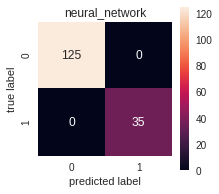

In [ ]:
#accuracy
print(f"train_accuracy: {accuracy_score(y_train, clf.predict(x_train))}")
print(f"val_accuracy: {accuracy_score(y_val, clf.predict(x_val))}")

#confusion_matrix
cmx_data = confusion_matrix(y_val, clf.predict(x_val)) 
df_cmx = pd.DataFrame(cmx_data)
plt.figure(figsize = (3,3))  
sns.heatmap(df_cmx, fmt='d', annot=True, square=True)
plt.title("neural_network")  
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.show()

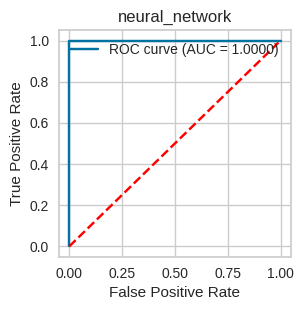

In [ ]:
# -------- ROC曲線, AUC -----------
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

fpr, tpr, thresholds = roc_curve(y_val, clf.predict_proba(x_val)[:, 0], pos_label=0) # 0:ガン患者の分類 
auc = roc_auc_score(y_val, clf.predict_proba(x_val)[:, 1])
plt.figure(figsize=(3, 3), dpi=100)
plt.plot(fpr, tpr, label='ROC curve (AUC = %.4f)'%auc)  
x = np.arange(0, 1, 0.01)  
plt.plot(x, x, c = 'red', linestyle = '--')  
plt.legend()
plt.title("neural_network")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.show()

In [ ]:
# obtain submission file from the prediction
submission['proba'] = clf.predict_proba(X_test)[:, 1]

# save submission
submission.to_csv('./submission.csv', index=False)

submission

,id,proba
0,-1.723412,1.000000e+00
...,...,...
199,1.723412,3.661963e-07


#**LightGBM**

In [ ]:
#Dataset

import scipy.stats
from sklearn import preprocessing

# target label
y = train_df['bankruptcy']

# predictor features
X = train_df.drop(['id', 'bankruptcy'], axis=1)
X = X.apply(scipy.stats.zscore, axis=0) #standardization

# list of categorical features
category_list = X.columns[X.dtypes=='category'].values.tolist()

# standardize testset
test_df = test_df.apply(scipy.stats.zscore, axis=0)


In [ ]:
from pandas._libs.tslibs.parsing import try_parse_date_and_time
# LightGBM / hyper parameters
lgbm_params = {
    'boosting_type': 'gbdt',            # Gradient Boosting Decision Tree
    'objective': 'binary',                 # binary classification
    'metric': 'auc',                         # evaluator：AUC
    
    'learning_rate': 0.05, 
    
    'num_leaves': 32, 
    
    'n_estimators': 100000, 
    'importance_type': 'gain', 
    
    'random_state': 123, 
}

params = {
    'boosting_type': 'gbdt',            # Gradient Boosting Decision Tree
    'objective': 'binary',
    'verbose': -1,
    "metric" : "None",
    'learning_rate': 0.05, 
    'num_leaves': 32, 
    'n_estimators': 100000, 
    'importance_type': 'gain',  
    'random_state': 123, 
}

#custom_metrics
import sklearn
from sklearn.metrics import f1_score
import numpy as np
from sklearn import datasets
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import lightgbm as lgb
from sklearn.metrics import precision_recall_curve
from sklearn import metrics
def f1(preds, data):
    y_true = data.get_label()
    y_pred = np.where(preds > 0.5, 1, 0)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    metric = 2*precision*recall/(precision+recall)
    return 'f1', metric, True

def accuracy(preds, data):
    """精度 (Accuracy) を計算する関数"""
    y_true = data.get_label()
    y_pred = np.where(preds > 0.5, 1, 0)
    metric = np.mean(y_true == y_pred)
    return 'accuracy', metric, True


def precision(preds, data):
    """適合率 (Precision) を計算する関数"""
    y_true = data.get_label()
    y_pred = np.where(preds > 0.5, 1, 0)
    metric = precision_score(y_true, y_pred)
    return 'precision', metric, True


def recall(preds, data):
    """再現率 (Recall) を計算する関数"""
    y_true = data.get_label()
    y_pred = np.where(preds > 0.5, 1, 0)
    metric = recall_score(y_true, y_pred)
    return 'recall', metric, True

def prroc(preds, data):
    """AUC を計算する関数"""
    y_true = data.get_label()
    y_pred = preds
    recall, precision, thresholds = precision_recall_curve(y_true, y_pred)
    metric = sklearn.metrics.auc(recall, precision)
    return 'prroc', metric, True

def aucroc(preds, data):
    """Precision_recall_AUC を計算する関数"""
    y_true = data.get_label()
    y_pred = preds
    metric = roc_auc_score(y_true, y_pred)
    return 'aucroc', metric, True


def metrics(preds, data): #複数onにすると、複数の指標でearly stoppingをしてしまうので注意
    """複数の評価指標を計算するための関数"""
    # リストでまとめて返せば良い
    return [
        accuracy(preds, data),
        #precision(preds, data),
        #recall(preds, data),
        #f1(preds, data),
        aucroc(preds, data),
        #prroc(preds, data), #これはうまくいかない
    ]

In [ ]:
#PythonAPI_lightGBM

from sklearn.metrics import log_loss


# StratifiedKFold-CV

# num of fold
folds = 5

# list of fixed models based on CV
models = []

# list of auc based on CV
auc = []

# prediction of valid data
out_of_fold = np.zeros(len(X))


# generate StratifiedKFold object and prepare train_index & valid_index
cv = list(StratifiedKFold(n_splits=folds, shuffle=True, random_state=123).split(X, y))


# CV
for n_fold in np.arange(folds):
    
    # obtain index for model fitting
    train_index = cv[n_fold][0]
    
    # obtain index for validation data
    valid_index = cv[n_fold][1]
    
    # predictor features for model fitting
    x_train_cv = X.iloc[train_index]
    
    # target label for model fitting
    y_train_cv =y.iloc[train_index]
    
    # predictor features for validation
    x_valid_cv = X.iloc[valid_index]
    
    # target label for validation
    y_valid_cv = y.iloc[valid_index]
    
    # データセットを生成する
    lgb_train = lgb.Dataset(x_train_cv, y_train_cv)
    lgb_eval = lgb.Dataset(x_valid_cv, y_valid_cv, reference=lgb_train)

    # 上記のパラメータでモデルを学習する
    evals_result = {}
    model = lgb.train(params, lgb_train, 
                  #valid_sets=lgb_eval,
                  verbose_eval=50,  # 50イテレーション毎に学習結果出力
                  num_boost_round=1000,  # 最大イテレーション回数指定
                  early_stopping_rounds=50,
                  # メトリックを追跡する対象のデータセット
                  valid_sets=[lgb_eval, lgb_train],
                  #valid_sets=[lgb_eval],
                  # 上記の名前
                  valid_names=['eval', 'train'],
                  # メトリックの履歴を残すオブジェクト
                  evals_result=evals_result,
                  # 独自メトリックを計算する関数
                  feval=metrics,
                 )
    
    
    # predict data for model fitting
    y_pred_train = model.predict(x_train_cv)
    
    # predict validation data
    y_pred_valid = model.predict(x_valid_cv)
    
    
    # AUC
    # data for model fitting
    temp_auc_train = roc_auc_score(y_train_cv, y_pred_train)
    
    # validation data
    temp_auc_valid = roc_auc_score(y_valid_cv, y_pred_valid)

    #calculate log_loss
    logloss = log_loss(y_valid_cv, y_pred_valid)

    print(f'\nfold: {n_fold}')
    print(f'log loss: {logloss}')
    
    # AUC
    print(f'auc(train_data) = {temp_auc_train:.4f}')
    print(f'auc(valid_data) = {temp_auc_valid:.4f}\n\n')
    
    # AUC append
    auc.append([temp_auc_train, temp_auc_valid])
    
    # model append
    models.append(model)
    
    # prediction result of validation data
    out_of_fold[valid_index] = y_pred_valid

# auc into NumPy type
auc_np = np.array(auc)

# mean of auc (train data)
auc_train_mean = auc_np[:, 0].mean()
print(f'auc(train_data)_mean = {auc_train_mean:.4f}')

# mean of auc (validation data)
auc_valid_mean = auc_np[:, 1].mean()
print(f'auc(valid_data)_mean = {auc_valid_mean:.4f}')
    

In [ ]:
#SKlearn_lightGBM

# StratifiedKFold-CV

# num of fold
folds = 5

# list of fixed models based on CV
models = []

# list of auc based on CV
auc = []

# prediction of valid data
out_of_fold = np.zeros(len(X))


# generate StratifiedKFold object and prepare train_index & valid_index
cv = list(StratifiedKFold(n_splits=folds, shuffle=True, random_state=123).split(X, y))


# CV
for n_fold in np.arange(folds):
    
    # obtain index for model fitting
    train_index = cv[n_fold][0]
    
    # obtain index for validation data
    valid_index = cv[n_fold][1]
    
    # predictor features for model fitting
    x_train_cv = X.iloc[train_index]
    
    # target label for model fitting
    y_train_cv = y.iloc[train_index]
    
    # predictor features for validation
    x_valid_cv = X.iloc[valid_index]
    
    # target label for validation
    y_valid_cv = y.iloc[valid_index]
    
    
    
    # generate LightGBM model object
    model = lgb.LGBMClassifier(**lgbm_params)
    
    
    # model fitting
    model.fit(
        x_train_cv, 
        y_train_cv, 
        eval_set = [(x_train_cv, y_train_cv), (x_valid_cv, y_valid_cv)], 
        early_stopping_rounds = 100, 
        categorical_feature = category_list,
        verbose = 50, 
    )
    
    
    # predict data for model fitting
    y_pred_train = model.predict_proba(x_train_cv, num_iteration=model.best_iteration_)[:, 1]
    
    # predict validation data
    y_pred_valid = model.predict_proba(x_valid_cv, num_iteration=model.best_iteration_)[:, 1]
    
    
    # AUC
    # data for model fitting
    temp_auc_train = roc_auc_score(y_train_cv, y_pred_train)
    
    # validation data
    temp_auc_valid = roc_auc_score(y_valid_cv, y_pred_valid)
    
    # AUC
    print(f'\nauc(train_data) = {temp_auc_train:.4f}')
    print(f'auc(valid_data) = {temp_auc_valid:.4f}\n')
    
    # AUC append
    auc.append([temp_auc_train, temp_auc_valid])
    
    
    # model append
    models.append(model)
    
    # prediction result of validation data
    out_of_fold[valid_index] = y_pred_valid
    
    
    # plot of model fitting curve
    lgb.plot_metric(model, ylim=(0, 1.2));

In [ ]:
# auc into NumPy type
auc_np = np.array(auc)

# mean of auc (train data)
auc_train_mean = auc_np[:, 0].mean()
print(f'auc(train_data)_mean = {auc_train_mean:.4f}')

# mean of auc (validation data)
auc_valid_mean = auc_np[:, 1].mean()
print(f'auc(valid_data)_mean = {auc_valid_mean:.4f}')

auc(train_data)_mean = 0.9948
auc(valid_data)_mean = 0.7953


In [ ]:
# Prediction of test data

# list of prediction based on each CV
preds_test = []


# predictor features of test data
x_test = test_df.drop(['id'], axis=1)


# predict with learned model based on CV
for model in models:
    
    # predict
    pred = model.predict_proba(x_test, num_iteration=model.best_iteration_)[:, 1]
    
    # append
    preds_test.append(pred)

In [ ]:
# preds_test into NumPy type
preds_test_np = np.array(preds_test)

# obtain its mean
preds_test_np_mean = preds_test_np.mean(axis=0)

# print
preds_test_np_mean

#**submission**

In [ ]:
# obtain submission file from the prediction
submission['proba'] = preds_test_np_mean

submission

,id,proba
0,800,0.113787
...,...,...
199,999,0.393655


In [ ]:
# save submission
submission.to_csv('./submission.csv', index=False)

#**Specify important factors**

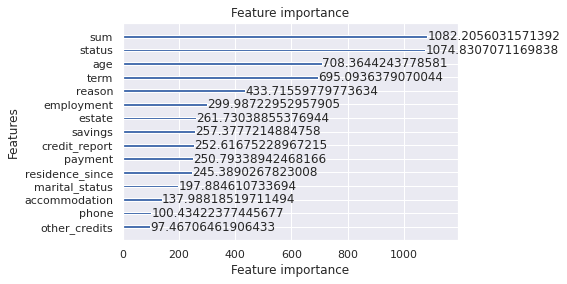

In [ ]:
# important features
lgb.plot_importance(model, importance_type='gain', max_num_features=15)

#**Manual decision tree**

In [30]:
import pandas as pd
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


# load train.csv
train_df = pd.read_csv('../input/bankruptcy-risk-prediction/train.csv')

# load test.csv
test_df = pd.read_csv('../input/bankruptcy-risk-prediction/test.csv')

# load submission_example.csv
submission = pd.read_csv('../input/bankruptcy-risk-prediction/submission_example.csv')


print(f'train_df.shape = {train_df.shape}')
print(f'test_df.shape = {test_df.shape}')
print(f'submission.shape = {submission.shape}')

pd.set_option('display.max_rows', 3)
pd.set_option('display.max_columns', 1000)

train_df
test_df


#nominal to proportional scale (名義尺度→連続尺度)
categories_obj = train_df.columns[train_df.dtypes=='object'].values.tolist()
categories_obj.extend(["dependents", "residence_since", "credits", "payment"])

#オブジェクト変数の一覧
for obj in categories_obj:
    indices = train_df.groupby(obj).count().index.to_list()
    print(f"Obj_categories: {obj}")
    print(f"  Index: {indices}")
    print("")

#全数閲覧
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)

train_df.shape = (800, 22)
test_df.shape = (200, 21)
submission.shape = (200, 2)
Obj_categories: guarantees
  Index: ['co-applicant', 'guarantor', 'none']

Obj_categories: reason
  Index: ['business', 'education', 'furniture or equipment', 'household appliances', 'new car', 'other', 'repairs', 'requalification', 'television or radio', 'used car']

Obj_categories: other_credits
  Index: ['bank', 'none', 'stores']

Obj_categories: credit_report
  Index: ['all credits at this bank paid back duly', 'critical account or other credits existing(not at this bank)', 'delay in paying off in the past', 'existing credits paid back duly till now', 'no credits or all paid']

Obj_categories: marital_status
  Index: ['female divorced or separated or married', 'male divorced or separated', 'male married or widowed', 'male single']

Obj_categories: employment
  Index: ['1 to 4 y.', '4 to 7 y.', '7+ y.', 'less-than 1 y.', 'unemployed']

Obj_categories: qualification
  Index: ['management or self-employed

In [142]:
df = pd.concat([train_df, test_df], axis=0, ignore_index=True)
cat_features = df.columns[df.dtypes == 'object'].to_list()
cat_features.append('bankruptcy')
num_features = df.columns[df.dtypes != 'object'].to_list()
num_features.remove('bankruptcy')
num_features.remove('id')

#drop the id column
df1 = df.drop(['id'], axis=1).copy()

#encode all the categorical variables with aggregated percentage of bankruptcy
df2 = df1.copy()
for feature in cat_features[:-1]:
    df2[feature] = df2.groupby([feature])['bankruptcy'].transform(np.mean)

#standardize all the numerical features
from sklearn.preprocessing import StandardScaler
df3 = df2.copy()
scaler = StandardScaler()
df3[df3.columns[:-1]] = scaler.fit_transform(df3[df3.columns[:-1]])

#split the data back to train and test sets
X_train = df3.iloc[:train_df.shape[0],:-1].copy()
y_train = df3.iloc[:train_df.shape[0],-1].copy()
X_test = df3.iloc[train_df.shape[0]:,:-1].copy()

## 年齢別解析

In [70]:
#Object項目の分布図を縦に並べて表示
import seaborn as sns
import matplotlib.pyplot as plt

def plot_groupby(df, categories_obj=categories_obj):
    sns.set()

    fig, axes = plt.subplots(len(categories_obj),1,figsize=(9,9*len(categories_obj)))   

    for i in range(len(categories_obj)):
        sns.barplot(x=categories_obj[i], y="bankruptcy", data=df, palette="Set3", ax=axes[i])

    # for j in range(len(categories_obj)):
    #     print(df.groupby(categories_obj[j]).count().index.to_list())
    
    plt.show()


def multi_plot_groupby(df1, df2, df3, categories_obj=categories_obj):
    sns.set()

    fig, axes = plt.subplots(len(categories_obj),3,figsize=(27,9*len(categories_obj)))   

    for i in range(len(categories_obj)):
        sns.barplot(x=categories_obj[i], y="bankruptcy", data=df1, palette="Set3", ax=axes[i,0])
        sns.barplot(x=categories_obj[i], y="bankruptcy", data=df2, palette="Set3", ax=axes[i,1])
        sns.barplot(x=categories_obj[i], y="bankruptcy", data=df3, palette="Set3", ax=axes[i,2])

    plt.show()


# #うまくいかないので却下
# def args_plot_groupby(categories_obj=categories_obj, *args):
#     sns.set()
#     print(len(args))
#     fig, axes = plt.subplots(len(categories_obj),len(args),figsize=(9*len(args),9*len(categories_obj)))   
    
#     for i in range(len(categories_obj)):
#         for j in range(len(args)):
#             sns.barplot(x=categories_obj[i], y="bankruptcy", data=args[j], palette="Set3", ax=axes[i,j])
#     plt.show()



In [ ]:
#若い人
young_df = train_df[train_df["age"] < 30]
young_df.reset_index
print(f"Age under 29: n={len(young_df)}")

young_df = young_df.sort_values(["bankruptcy", "accommodation"])
young_df.reset_index

plot_groupby(young_df)

In [ ]:
#中年
middle_df = train_df[train_df["age"] >= 30]
middle_df = middle_df[middle_df["age"] < 50]
middle_df.reset_index
middle_df
print(f"Age between 30 and 49: n={len(middle_df)}")

plot_groupby(middle_df)

In [ ]:
#高齢
old_df = train_df[train_df["age"] >= 50]
old_df.reset_index
old_df
print(f"Age after 50: n={len(old_df)}")

plot_groupby(old_df)

In [ ]:
#2000未満
under2000_df = train_df[train_df["sum"] < 2000]
under2000_df.reset_index
print(f"sum under 2000: n={len(under2000_df)}")

under2000_df = under2000_df.sort_values(["bankruptcy", "accommodation"])
under2000_df.reset_index
plot_groupby(under2000_df)

In [ ]:
#2000-4000
from2000to4000_df = train_df[train_df["sum"] >= 2000]
from2000to4000_df = from2000to4000_df[from2000to4000_df["sum"] < 4000]
from2000to4000_df.reset_index
print(f"sum from2000to4000: n={len(from2000to4000_df)}")

from2000to4000_df = from2000to4000_df.sort_values(["bankruptcy", "accommodation"])
from2000to4000_df.reset_index
plot_groupby(from2000to4000_df)

In [ ]:
#over4000
over4000_df = train_df[train_df["sum"] < 2000]
over4000_df.reset_index
print(f"sum over4000: n={len(over4000_df)}")

over4000_df = over4000_df.sort_values(["bankruptcy", "accommodation"])
over4000_df.reset_index
plot_groupby(over4000_df)

#オブジェクト変数の一覧
for obj in categories_obj:
    indices = train_df.groupby(obj).count().index.to_list()
    print(f"Obj_categories: {obj}")
    print(f"  Index: {indices}")
    print("")

In [ ]:
# 1. young --> guarantees == "co-applicant"  若くて保証人を引き受けてしまい？破産
young_co_applicant_df = young_df[young_df["guarantees"]=="co-applicant"]
plot_groupby(young_co_applicant_df)
young_co_applicant_df

In [ ]:
"""
雑感

immigrant >> no immigrant

"""

## 要素別解析

In [110]:
#statusが"less-than 0 cu", "0 to 200 cu"だと圧倒的に破産しやすい
df1.groupby("status").mean()

,sum,term,payment,credits,age,residence_since,dependents,bankruptcy
status,,,,,,,,
0 to 200 cu,3827.561338,22.680297,2.877323,1.356877,34.081784,2.743494,1.115242,0.411504
greater-than 200 cu or salary assignments for at least 1 year,2177.650794,17.349206,2.793651,1.317460,37.190476,2.571429,1.142857,0.218182
less-than 0 cu,3175.218978,21.339416,3.058394,1.379562,35.339416,3.003650,1.189781,0.473684
no checking account,3133.101523,19.954315,3.007614,1.474619,36.426396,2.847716,1.159898,0.112903


In [ ]:
#Statusが低い人
status_low_df = pd.concat([df1[df1["status"] == "0 to 200 cu"], df1[df1["status"] == "less-than 0 cu"]])

#Statusが高い人
status_high_df = pd.concat([df1[df1["status"] == "greater-than 200 cu or salary assignments for at least 1 year"], df1[df1["status"] == "no checking account"]])

plot_groupby(status_high_df)

#**主成分分析をしてみる**

https://free.kikagaku.ai/tutorial/basic_of_machine_learning/learn/machine_learning_unsupervised

In [156]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#主成分の数
n_component = 2

In [157]:
# モデルの定義
from sklearn.decomposition import PCA
pca = PCA(n_components=n_component, random_state=0)

# モデルの学習
pca.fit(X_train)

PCA(n_components=2, random_state=0)

In [158]:
# 分散の確認
pca.get_covariance()

# 主成分分析の適用
x_transformed = pca.transform(X_train)

# 主成分分析適用後のデータの確認
pd.DataFrame(x_transformed, columns=[f"第{i+1}主成分" for i in range(n_component)]).head(10)

,第1主成分,第2主成分
0,-0.454987,-1.725270
1,-1.690158,0.977201
2,-1.333653,-1.254557
3,0.258358,0.758712
4,1.862277,1.133738
5,2.459128,-0.631665
6,-0.620324,-1.439486
7,2.062340,-0.068678
8,-1.693530,-0.930671
9,0.247572,0.348526


In [159]:
for i in range(n_component):
    print(f"第{i+1}主成分の寄与率: {pca.explained_variance_ratio_[i]}")


第1主成分の寄与率: 0.11674240202670182
第2主成分の寄与率: 0.10283944910647502


In [160]:
# 0, 1 の 2 つのクラスがあることを確認
np.unique(y_train)

array([0., 1.])

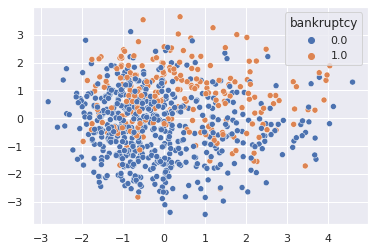

In [161]:
# 次元削減後のデータを可視化
sns.scatterplot(x_transformed[:, 0], x_transformed[:, 1], 
             hue=y_train, palette=sns.color_palette(n_colors=2));